## MITgcm Example 

xgcm is developed in close coordination with the [xmitgcm](http://xmitgcm.readthedocs.io/) package.
The metadata in datasets constructed by xmitgcm should always be compatible with xgcm's expectations.
xmitgcm is necessary for reading MITgcm's binary MDS file format.
However, for this example, the MDS files have already been converted and saved as netCDF.

Below are some example of how to make calculations on mitgcm-style datasets using xgcm.

First we import xarray and xgcm:

In [1]:
#! pip install git+https://github.com/xgcm/xgcm.git

In [2]:
import xarray as xr
import numpy as np
import xgcm
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)

Now we open the example dataset, which is stored with the xgcm github repository in the datasets folder.

In [3]:
#!wget http://www.ldeo.columbia.edu/~rpa/mitgcm_example_dataset.nc

In [4]:
dir(xgcm.grid.Grid)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply_vector_function',
 '_assign_face_connections',
 'cumsum',
 'diff',
 'diff_2d_vector',
 'interp',
 'interp_2d_vector']

In [5]:
ds = xr.open_dataset('mitgcm_example_dataset.nc')
ds

<xarray.Dataset>
Dimensions:               (XC: 90, XG: 90, YC: 40, YG: 40, Z: 15, Zl: 15, Zp1: 16, Zu: 15, layer_1RHO_bounds: 31, layer_1RHO_center: 30, layer_1RHO_interface: 29, time: 1)
Coordinates:
    iter                  (time) int64 ...
  * time                  (time) timedelta64[ns] 11:00:00
  * XC                    (XC) float32 2.0 6.0 10.0 14.0 18.0 22.0 26.0 30.0 ...
  * YC                    (YC) float32 -78.0 -74.0 -70.0 -66.0 -62.0 -58.0 ...
  * XG                    (XG) float32 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0 ...
  * YG                    (YG) float32 -80.0 -76.0 -72.0 -68.0 -64.0 -60.0 ...
  * Z                     (Z) float32 -25.0 -85.0 -170.0 -290.0 -455.0 ...
  * Zp1                   (Zp1) float32 0.0 -50.0 -120.0 -220.0 -360.0 ...
  * Zu                    (Zu) float32 -50.0 -120.0 -220.0 -360.0 -550.0 ...
  * Zl                    (Zl) float32 0.0 -50.0 -120.0 -220.0 -360.0 -550.0 ...
    rA                    (YC, XC) float32 ...
    dxG                

In [6]:
ds.Eta

<xarray.DataArray 'Eta' (time: 1, YC: 40, XC: 90)>
array([[[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [-0.702411, -0.694586, ..., -0.694789, -0.709546],
        [-0.656158, -0.659816, ..., -0.623395, -0.649   ]]], dtype=float32)
Coordinates:
    iter     (time) int64 ...
  * time     (time) timedelta64[ns] 11:00:00
  * XC       (XC) float32 2.0 6.0 10.0 14.0 18.0 22.0 26.0 30.0 34.0 38.0 ...
  * YC       (YC) float32 -78.0 -74.0 -70.0 -66.0 -62.0 -58.0 -54.0 -50.0 ...
    rA       (YC, XC) float32 ...
    Depth    (YC, XC) float32 ...
Attributes:
    standard_name:  ETAN
    long_name:      Surface Height Anomaly
    units:          m

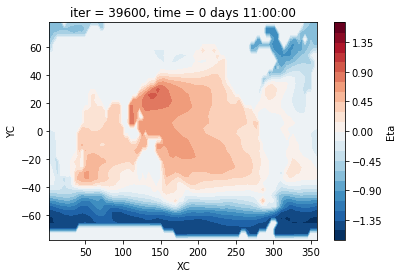

In [7]:
ds.Eta[0].plot.contourf(levels=30)


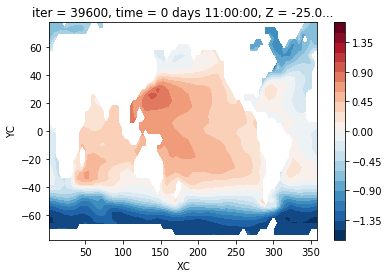

In [8]:
surf_mask_c = ds.hFacC[0] > 0
ds.Eta[0].where(surf_mask_c).plot.contourf(levels=30)

### Creating the grid object

Next we create a `Grid` object from the dataset.
We need to tell xgcm that the `X` and `Y` axes are periodic.
(The other axes will be assumed to be non-periodic.)

In [9]:
xgcm.Grid?

Init signature: xgcm.Grid(ds, check_dims=True, periodic=True, default_shifts={}, face_connections=None, coords=None)
Docstring:     
An object with multiple :class:`xgcm.Axis` objects representing different
independent axes.
Init docstring:
Create a new Grid object from an input dataset.

Parameters
----------
ds : xarray.Dataset
    Contains the relevant grid information. Coordinate attributes
    should conform to Comodo conventions [1]_.
check_dims : bool, optional
    Whether to check the compatibility of input data dimensions before
    performing grid operations.
periodic : {True, False, list}
    Whether the grid is periodic (i.e. "wrap-around"). If a list is
    specified (e.g. ``['X', 'Y']``), the axis names in the list will be
    be periodic and any other axes founds will be assumed non-periodic.
default_shifts : dict
    A dictionary of dictionaries specifying default grid position
    shifts (e.g. ``{'X': {'center': 'left', 'left': 'center'}}``)
face_connections : dict
   

In [10]:
ds.XC.attrs

OrderedDict([('standard_name', 'longitude'),
             ('long_name', 'longitude'),
             ('units', 'degrees_east'),
             ('coordinate', 'YC XC'),
             ('axis', 'X')])

In [11]:
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>
Z Axis (not periodic):
  * center   Z (15) --> left
  * left     Zl (15) --> center
  * outer    Zp1 (16) --> center
  * right    Zu (15) --> center
X Axis (periodic):
  * center   XC (90) --> left
  * left     XG (90) --> center
1RHO Axis (not periodic):
  * center   layer_1RHO_center (30) --> outer
  * outer    layer_1RHO_bounds (31) --> center
  * inner    layer_1RHO_interface (29) --> center
Y Axis (periodic):
  * center   YC (40) --> left
  * left     YG (40) --> center
T Axis (not periodic):
  * center   time (1)

In [12]:
grid.interp?

Signature: grid.interp(da, axis, **kwargs)
Docstring:
Interpolate neighboring points to the intermediate grid point along
this axis.

Parameters
----------
axis : str
    Name of the axis on which ot act
da : xarray.DataArray
    The data on which to operate
to : {'center', 'left', 'right', 'inner', 'outer'}
    The direction in which to shift the array. If not specified,
    default will be used.
boundary : {None, 'fill', 'extend'}
    A flag indicating how to handle boundaries:

    * None:  Do not apply any boundary conditions. Raise an error if
      boundary conditions are required for the operation.
    * 'fill':  Set values outside the array boundary to fill_value
      (i.e. a Neumann boundary condition.)
    * 'extend': Set values outside the array to the nearest array
      value. (i.e. a limited form of Dirichlet boundary condition.)

Returns
-------
da_i : xarray.DataArray
    The interpolated data
File:      ~/miniconda3/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py

In [13]:
ds.THETA.dims

('time', 'Z', 'YC', 'XC')

In [14]:
theta_x_interp = grid.interp(ds.THETA, 'X')
theta_x_interp

<xarray.DataArray (time: 1, Z: 15, YC: 40, XG: 90)>
array([[[[ 0.      , ...,  0.      ],
         ...,
         [-0.113758, ..., -0.320469]],

        ...,

        [[ 0.      , ...,  0.      ],
         ...,
         [ 0.      , ...,  0.      ]]]], dtype=float32)
Coordinates:
  * time     (time) timedelta64[ns] 11:00:00
  * Z        (Z) float32 -25.0 -85.0 -170.0 -290.0 -455.0 -670.0 -935.0 ...
  * YC       (YC) float32 -78.0 -74.0 -70.0 -66.0 -62.0 -58.0 -54.0 -50.0 ...
  * XG       (XG) float32 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0 32.0 36.0 ...

In [ ]:
theta_z_interp = grid.interp(ds.THETA, 'Z', boundary='extend')
theta_z_interp

In [ ]:
ds.THETA[0,5].plot()

In [ ]:
theta_x_interp[0,5,].plot()

In [ ]:
ds.THETA.sel(XC=200, YC=45,
             method='nearest').plot.line(y='Z', marker='o',
                                         label='original')
theta_z_interp.sel(XC=200, YC=45,
                   method='nearest').plot.line(y='Zl', marker='o',
                                               label='interpolated')
# plt.ylim([-500, 0])
plt.legend()

### Kinetic Energy

Finally, we plot the kinetic energy $1/2 (u^2 + v^2)$ by interpoloting both quantities the cell center point.

In [ ]:
# an example of calculating kinetic energy
ke = 0.5*(grid.interp((ds.U*ds.hFacW)**2, 'X') + 
          grid.interp((ds.V*ds.hFacS)**2, 'Y'))
print(ke)
ke[0,0].plot()

### Vorticity and Strain
Here we compute more dervied quantities from the velocity field.

The vertical component of the vorticity is a fundamental quantity of interest in ocean circulation theory. It is defined as

$$ \zeta = - \frac{\partial u}{\partial y} + \frac{\partial v}{\partial x} \ . $$

On the c-grid, a finite-volume representation is given by

$$ \zeta =  (- \delta_j \Delta x_c u + \delta_i \Delta y_c v ) / A_\zeta \ . $$

In xgcm, we calculate this quanity as

In [ ]:
zeta = (-grid.diff(ds.U * ds.dxC, 'Y') +
         grid.diff(ds.V * ds.dyC, 'X'))/ds.rAz
zeta

...which we can see is located at the `YG, XG` horizontal position (also commonly called the vorticity point).

We plot the vertical integral of this quantity, i.e. the barotropic vorticity:

In [ ]:
zeta_bt = (zeta * ds.drF).sum(dim='Z')
zeta_bt.plot(vmax=2e-4)

A different way to calculate the barotropic vorticity is to take the curl of the vertically integrated velocity.
This formulation also allows us to incorporate the $h$ factors representing partial cell thickness.

In [ ]:
u_bt = (ds.U * ds.hFacW * ds.drF).sum(dim='Z')
v_bt = (ds.V * ds.hFacS * ds.drF).sum(dim='Z')
zeta_bt_alt = (-grid.diff(u_bt * ds.dxC, 'Y') + grid.diff(v_bt * ds.dyC, 'X'))/ds.rAz
zeta_bt_alt.plot(vmax=2e-4)

Another interesting quantity is the horizontal strain, defined as

$$ s = \frac{\partial u}{\partial x} - \frac{\partial v}{\partial y} \ . $$

On the c-grid, a finite-volume representation is given by

$$ s =  (\delta_i \Delta y_g u - \delta_j \Delta x_g v ) / A_c \ . $$

In [ ]:
strain = (grid.diff(ds.U * ds.dyG, 'X') - grid.diff(ds.V * ds.dxG, 'Y')) / ds.rA
strain[0,0].plot()

### Barotropic Transport Streamfunction

We can use the barotropic velocity to calcuate the barotropic transport streamfunction, defined via

$$ u_{bt} = - \frac{\partial \Psi}{\partial y} \ , \ \ v_{bt} = \frac{\partial \Psi}{\partial x} \ .$$

We calculate this by integrating $u_{bt}$ along the Y axis using the grid object's `cumsum` method:

In [ ]:
psi = grid.cumsum(-u_bt * ds.dyG, 'Y', boundary='fill')
psi

We see that xgcm automatically shifted the Y-axis position from center (YC) to left (YG) during the cumsum operation.

We convert to sverdrups and plot with a contour plot.

In [ ]:
(psi[0] / 1e6).plot.contourf(levels=np.arange(-160, 40, 5))

## Tracer Budget Example

In [ ]:
adv_flux_div = (grid.diff(ds.ADVx_TH, 'X') +
                grid.diff(ds.ADVy_TH, 'Y') +
                grid.diff(ds.ADVr_TH, 'Z', boundary='fill'))
adv_flux_div

In [ ]:
diff_flux_div = (grid.diff(ds.DFxE_TH, 'X') +
                grid.diff(ds.DFyE_TH, 'Y') +
                grid.diff(ds.DFrE_TH + ds.DFrI_TH, 'Z', boundary='fill'))
diff_flux_div

In [ ]:
diff_flux_div.sum(dim=['XC', 'YC']).plot.line(y='Z', marker='.', label='diffusion')
adv_flux_div.sum(dim=['XC', 'YC']).plot.line(y='Z', marker='.', label='advection')
plt.grid()
plt.legend()